In [16]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import warnings
import calendar
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from time import sleep

In [17]:
from helpers.scrape import get_first_basket
from helpers.utils import getId


def get_monthly_games(month_url) :

    url = f'https://www.basketball-reference.com/{month_url}'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'lxml')
    table = soup.find('table')
    while table.find_all('tr', class_ = 'thead') :
        table.find('tr', class_ = 'thead').decompose()
    games = pd.read_html(str(table))[0].rename(columns = {'Start (ET)': 'Time'})
    games['Date'] = pd.to_datetime(games['Date'])
    games['Home'] = [x['href'].split('/')[2] for x in table.find_all('a', href = True) if 'teams' in x['href']][1::2]
    games['Away'] = [x['href'].split('/')[2] for x in table.find_all('a', href = True) if 'teams' in x['href']][0::2]
    games['game_id'] = [getId(x) for x in table.find_all('a', href = True) if 'boxscores' in x['href']][1::2]

    return games[['game_id', 'Date', 'Time', 'Home', 'Away']]

In [18]:
months = list(calendar.month_name)[1:]
seasons = [2018]

for season in seasons :
    url = f'https://www.basketball-reference.com/leagues/NBA_{season}_games.html'
    page = requests.get(url)
    if page.status_code == 429 :
        raise ValueError('Rate limited...')
    soup = BeautifulSoup(page.content, 'lxml')
    month_urls = [x['href'] for x in soup.find_all('a', href = True) if 'games' in x['href'] 
                    and any(m.lower() in x['href'] for m in months)]

    for m, month_url in enumerate(month_urls) :

        games_monthly = get_monthly_games(month_url)
        games_monthly['season'] = season

        first_basket_info = []
        for i, gameId in enumerate(games_monthly['game_id'])  :

            print(f'[{round(100*(i+1)/len(games_monthly))}%...] season :  {season-1}-{season}, month :  {month_url.split("-")[-1].split(".")[0]} ({gameId})')
            sleep(5)
            first_basket_info.append(get_first_basket(gameId))


        first_basket_df = pd.concat(first_basket_info)
        first_basket_df = games_monthly.merge(first_basket_df, on = ['game_id', 'Home', 'Away'], how = 'inner')
        if m == 0 :
            first_basket_df.to_csv(f'data/first_basket_{season}.csv', index = False)
        else :
            first_basket_df.to_csv(f'data/first_basket_{season}.csv', mode = 'a', header = False, index = False)

[1%...] season :  2017-2018, month :  october (201710170CLE)
[2%...] season :  2017-2018, month :  october (201710170GSW)
[3%...] season :  2017-2018, month :  october (201710180DET)
[4%...] season :  2017-2018, month :  october (201710180IND)
[5%...] season :  2017-2018, month :  october (201710180ORL)
[6%...] season :  2017-2018, month :  october (201710180WAS)
[7%...] season :  2017-2018, month :  october (201710180BOS)
[8%...] season :  2017-2018, month :  october (201710180MEM)
[9%...] season :  2017-2018, month :  october (201710180DAL)
[10%...] season :  2017-2018, month :  october (201710180UTA)
[11%...] season :  2017-2018, month :  october (201710180SAS)
[12%...] season :  2017-2018, month :  october (201710180PHO)
[12%...] season :  2017-2018, month :  october (201710180SAC)
[13%...] season :  2017-2018, month :  october (201710190TOR)
[14%...] season :  2017-2018, month :  october (201710190OKC)
[15%...] season :  2017-2018, month :  october (201710190LAL)
[16%...] season :

ValueError: not enough values to unpack (expected 3, got 2)

In [19]:
gameId

'201710220LAL'

In [1]:
import requests

In [4]:
page = requests.get('https://www.nba.com/stats/draft/combine-anthro')

In [10]:
type(page.content)

bytes

In [19]:
str(page.content)[1000:1030]

'nk rel="mask-icon" href="/safa'

In [21]:
'<div' in str(page.content)

True

In [22]:
from bs4 import BeautifulSoup

In [23]:
soup = BeautifulSoup(page.content)

In [24]:
soup

<!DOCTYPE html>
<html data-build="17759" data-version="4.54.2" lang="en"><head><meta charset="utf-8"/><link href="/site-manifest.json" rel="manifest"/><meta content="width=device-width,initial-scale=1,minimum-scale=1,maximum-scale=1,user-scalable=no" name="viewport"/><script src="/newrelic/newrelic-prod.js"></script><script id="theme-loader" src="/theme-loader.js"></script><title>Draft Combine Anthrometric | Stats | NBA.com</title><meta content="NBA Draft Combine Anthrometric data" name="description"/><link href="/favicon.ico" rel="icon"/><link href="/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/><link href="/favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/><link href="/apple-touch-icon.png" rel="apple-touch-icon"/><link href="/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/><link href="/apple-touch-icon.png" rel="apple-touch-icon" sizes="120x120"/><link href="/apple-touch-icon.png"/><meta content="#da532c" name="msapplication-TileColor"/><lin

In [29]:
'arrington' in str(page.content)

False

In [30]:
page._content

b'<!DOCTYPE html><html lang="en" data-version="4.54.2" data-build="17759"><head><meta charSet="utf-8"/><link rel="manifest" href="/site-manifest.json"/><meta name="viewport" content="width=device-width,initial-scale=1,minimum-scale=1,maximum-scale=1,user-scalable=no"/><script src="/newrelic/newrelic-prod.js"></script><script id="theme-loader" src="/theme-loader.js"></script><title>Draft Combine Anthrometric | Stats | NBA.com</title><meta name="description" content="NBA Draft Combine Anthrometric data"/><link rel="icon" href="/favicon.ico"/><link rel="icon" type="image/png" sizes="32x32" href="/favicon-32x32.png"/><link rel="icon" type="image/png" sizes="16x16" href="/favicon-16x16.png"/><link rel="apple-touch-icon" href="/apple-touch-icon.png"/><link rel="apple-touch-icon" sizes="180x180" href="/apple-touch-icon.png"/><link rel="apple-touch-icon" sizes="120x120" href="/apple-touch-icon.png"/><link href="/apple-touch-icon.png"/><meta name="msapplication-TileColor" content="#da532c"/><li

In [31]:
soup.get_text

<bound method PageElement.get_text of <!DOCTYPE html>
<html data-build="17759" data-version="4.54.2" lang="en"><head><meta charset="utf-8"/><link href="/site-manifest.json" rel="manifest"/><meta content="width=device-width,initial-scale=1,minimum-scale=1,maximum-scale=1,user-scalable=no" name="viewport"/><script src="/newrelic/newrelic-prod.js"></script><script id="theme-loader" src="/theme-loader.js"></script><title>Draft Combine Anthrometric | Stats | NBA.com</title><meta content="NBA Draft Combine Anthrometric data" name="description"/><link href="/favicon.ico" rel="icon"/><link href="/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/><link href="/favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/><link href="/apple-touch-icon.png" rel="apple-touch-icon"/><link href="/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/><link href="/apple-touch-icon.png" rel="apple-touch-icon" sizes="120x120"/><link href="/apple-touch-icon.png"/><meta content="#da532c

In [36]:
table_str = """
PLAYER	POS	BODY FAT %	HAND LENGTH (inches)	HAND WIDTH (inches)	HEIGHT W/O SHOES	HEIGHT W/ SHOES	STANDING REACH	WEIGHT (LBS)	WINGSPAN
Michael Ajayi	SF	-%	9.50	9.75	6' 5.75''		8' 10.50''	227.8	7' 0.75''
Melvin Ajinca	SF	-%	8.50	9.75	6' 7.25''		8' 10.5''	213.8	6' 7.5''
Trey Alexander	SG	-%	8.75	10.00	6' 3.25''		8' 5.50''	187.0	6' 10.50''
Izan Almansa	C	-%	9.25	9.25	6' 9.25''		9' 2.00''	219.6	7' 1.00''
Reece Beekman	PG	-%	8.50	9.00	6' 1.25''		8' 4.00''	196.4	6' 6.50''
Adem Bona	C	-%	9.50	10.00	6' 8.25''		9' 0.00''	243.2	7' 3.75''
Trevon Brazile	PF	-%	9.00	10.25	6' 9.25''		9' 0.50''	215.0	7' 3.75''
Jalen Bridges	SF	-%	9.00	10.00	6' 6.75''		8' 9.00''	213.4	6' 10.00''
Matas Buzelis	SF	-%	8.50	9.25	6' 8.75''		8' 9.50''	197.0	6' 10.00''
Carlton Carrington	PG	-%	8.50	9.25	6' 3.75''		8' 3.00''	194.8	6' 8.00''
Devin Carter	SG	-%	8.75	9.00	6' 2.25''		8' 2.00''	193.0	6' 8.75''
Stephon Castle	SG	-%	8.75	8.75	6' 5.50''		8' 6.00''	210.0	6' 9.00''
Ulrich Chomche	C	-%	9.25	10.25	6' 10.25''		9' 1.00''	232.4	7' 4.00''
Cam Christie	SG	-%	8.00	8.00	6' 4.50''		8' 5.50''	190.4	6' 8.00''
Nique Clifford	SF	-%	8.00	9.00	6' 5.00''		8' 6.00''	198.6	6' 8.00''
Donovan Clingan	C	-%	10.00	10.25	7' 1.75''		9' 7.00''	282.0	7' 6.75''
Isaiah Collier	PG	-%	8.50	9.00	6' 2.50''		8' 1.50''	204.6	6' 4.75''
Tristan Da Silva	PF	-%	9.00	9.50	6' 8.25''		8' 8.50''	216.8	6' 10.25''
Pacome Dadiet	SF	-%	8.50	9.00	6' 7.75''		8' 11.5''	216.8	6' 9''
N'Faly Dante	C	-%	9.25	10.00	6' 10.00''		9' 3.00''	260.2	7' 6.00''
Robert Dillingham	PG	-%	8.00	8.25	6' 1.00''		7' 11.00''	164.2	6' 3.00''
Nikola Djurisic	SF	-%	8.50	10.00	6' 7.00''		8' 6.50''	208.8	6' 8.00''
Ryan Dunn	PF	-%	9.00	9.75	6' 6.25''		8' 7.00''	213.6	7' 1.50''
Zach Edey	C	-%	10.00	10.75	7' 3.75''		9' 7.00''	299.0	7' 10.75''
Justin Edwards	SF	-%	8.75	8.75	6' 6.00''		8' 6.50''	209.4	6' 10.00''
Jesse Edwards	C	-%	9.25	10.00	6' 11.50''		9' 3.00''	236.0	7' 5.00''
Boogie Ellis	PG-SG	-%	9.00	9.50	6' 0.75''		8' 2.00''	185.0	6' 7.00''
Kyle Filipowski	PF	-%	8.75	9.50	6' 10.75''		8' 11.00''	229.8	6' 10.50''
Trentyn Flowers	SF	-%	8.75	9.50	6' 6.50''		8' 4.50''	201.4	6' 8.25''
Enrique Freeman	PF	-%	8.75	10.00	6' 7.25''		9' 0.00''	212.0	7' 2.00''
Johnny Furphy	SF	-%	8.00	9.50	6' 7.50''		8' 8.50''	188.8	6' 8.00''
Kyshawn George	SF	-%	9.00	10.25	6' 7.00''		8' 9.00''	208.8	6' 10.25''
Tyon Grant-Foster	SF	-%	8.75	9.25	6' 5.75''		8' 8.00''	215.2	6' 11.75''
PJ Hall	C	-%	9.00	9.75	6' 8.25''		8' 7.50''	239.6	7' 1.50''
Coleman Hawkins	PF	-%	8.75	8.75	6' 8.25''		8' 11.00''	215.2	7' 0.00''
Ron Holland II	SF	-%	8.75	9.00	6' 6.50''		8' 8.00''	196.8	6' 10.75''
DaRon Holmes II	C	-%	8.75	9.00	6' 8.75''		9' 0.00''	236.2	7' 1.00''
Ariel Hukporti	C	-%	9.25	10.25	6' 10.75''		9' 3.00''	246.2	7' 2.50''
Oso Ighodaro	C	-%	9.00	10.00	6' 9.50''		8' 8.50''	222.0	6' 11.00''
Harrison Ingram	SF	-%	9.00	10.25	6' 5.25''		8' 6.50''	233.6	7' 0.25''
Bronny James	SG	-%	8.50	9.50	6' 1.50''		8' 2.50''	210.4	6' 7.25''
AJ Johnson	SG	-%	8.50	8.50	6' 4.25''		8' 6.00''	167.0	6' 8.50''
Keshad Johnson	PF	-%	9.25	10.75	6' 6.25''		8' 7.00''	224.0	6' 10.25''
Dillon Jones	SF	-%	9.00	9.25	6' 4.50''		8' 4.50''	236.8	6' 11.00''
David Jones	SF	-%	8.50	9.50	6' 3.50''		8' 4.00''	211.2	6' 6.75''
Isaac Jones	C	-%	9.25	10.25	6' 7.75''		9' 0.00''	235.0	7' 3.00''
Alex Karaban	PF	-%	8.75	9.25	6' 6.50''		8' 10.50''	219.2	6' 11.00''
Bobi Klintman	PF	-%	8.75	10.00	6' 8.75''		8' 10.50''	212.2	6' 11.00''
Dalton Knecht	SF	-%	8.50	9.50	6' 5.25''		8' 7.50''	212.2	6' 9.00''
Tyler Kolek	PG	-%	8.25	9.50	6' 1.25''		7' 11.00''	196.6	6' 2.75''
Pelle Larsson	SG	-%	8.75	10.25	6' 5.25''		8' 6.00''	212.4	6' 7.50''
Jared McCain	SG	-%	8.25	9.50	6' 2.00''		8' 2.00''	203.2	6' 3.50''
Kevin McCullar Jr.	SF	-%	8.75	9.50	6' 5.25''		8' 7.00''	205.8	6' 9.00''
Yves Missi	C	-%	9.50	10.00	6' 10.75''		9' 1.50''	229.4	7' 2.00''
Ajay Mitchell	PG	-%	8.50	8.50	6' 3.25''		8' 5.00''	197.0	6' 6.25''
Jonathan Mogbo	PF	-%	8.75	8.75	6' 6.25''		9' 0.50''	217.2	7' 2.00''
Tristen Newton	PG	-%	8.50	9.00	6' 3.25''		8' 4.00''	191.8	6' 6.75''
Juan Nunez	PG	-%	8.50	9.50	6' 4''		8' 6''	205.6	6' 6.5''
Quinten Post	C	-%	9.25	10.00	7' 0.00''		9' 4.00''	244.4	7' 2.50''
Antonio Reeves	SG	-%	9.00	10.00	6' 4.50''		8' 4.50''	186.6	6' 8.25''
Zaccharie Risacher	SF	-%	8.50	8.75	6' 8.5''		8' 11''	194.6	6' 9.5''
Jaxson Robinson	SG	-%	9.00	9.50	6' 4.75''		8' 7.00''	188.6	6' 11.25''
Tidjane Salaun	PF	-%	8.50	9.75	6' 8.75''		9' 2''	217.4	7' 1.5''
Hunter Sallis	SG	-%	8.00	9.50	6' 3.50''		8' 4.50''	179.4	6' 9.75''
Payton Sandfort	SF	-%	8.50	9.00	6' 6.25''		8' 8.00''	212.0	6' 8.00''
Alexandre Sarr	C	-%	9.00	10.00	6' 11.75''		9' 2.00''	224.2	7' 4.25''
Baylor Scheierman	SF	-%	9.25	9.75	6' 6.25''		8' 6.50''	201.6	6' 8.25''
Mark Sears	PG	-%	8.00	8.50	5' 10.25''		7' 8.00''	192.4	6' 2.00''
Terrence Shannon Jr.	SF	-%	8.75	8.50	6' 5.75''		8' 4.00''	219.4	6' 8.75''
Jamal Shead	PG	-%	8.25	8.75	6' 0.25''		8' 0.00''	200.8	6' 3.00''
Reed Sheppard	PG	-%	7.75	9.00	6' 1.75''		7' 9.50''	181.6	6' 3.25''
KJ Simpson	PG	-%	8.25	9.25	6' 0.25''		7' 9.50''	187.0	6' 4.50''
Tyler Smith	PF	-%	8.50	9.00	6' 9.00''		8' 9.00''	223.8	7' 1.00''
Cam Spencer	SG	-%	8.50	9.75	6' 3.00''		8' 2.50''	201.8	6' 5.00''
Nae'Qwan Tomlin	PF	-%	9.00	10.00	6' 8.25''		9' 1.00''	205.0	7' 2.50''
Nikola Topic	PG	-%	8.00	9.00	6' 5.75''		8' 6''	203.0	6' 5.5''
JT Toppin	PF	-%	9.25	9.25	6' 7.00''		8' 10.00''	221.0	7' 0.50''
Jaylon Tyson	SF	-%	8.25	9.50	6' 5.50''		8' 6.50''	218.2	6' 8.00''
Ja'Kobe Walter	SG	-%	8.75	9.75	6' 4.25''		8' 6.50''	197.6	6' 10.00''
Kel'el Ware	C	-%	9.50	10.25	6' 11.75''		9' 4.50''	230.0	7' 4.50''
Jamir Watkins	SF	-%	9.00	9.50	6' 5.00''		8' 8.00''	211.6	6' 10.75''
Jaylen Wells	SF	-%	8.25	9.25	6' 6.50''		8' 7.50''	206.2	6' 7.25''
Cody Williams	SF	-%	8.25	9.00	6' 6.50''		8' 7.00''	178.4	7' 1.00''
"""

In [87]:
with open('data/combine_anthro/report_2024.txt', 'r') as f:
    r = f.read()

In [88]:
r

"PLAYER\tPOS\tBODY FAT %\tHAND LENGTH (inches)\tHAND WIDTH (inches)\tHEIGHT W/O SHOES\tHEIGHT W/ SHOES\tSTANDING REACH\tWEIGHT (LBS)\tWINGSPAN\nMichael Ajayi\tSF\t-%\t9.50\t9.75\t6' 5.75''\t\t8' 10.50''\t227.8\t7' 0.75''\nMelvin Ajinca\tSF\t-%\t8.50\t9.75\t6' 7.25''\t\t8' 10.5''\t213.8\t6' 7.5''\nTrey Alexander\tSG\t-%\t8.75\t10.00\t6' 3.25''\t\t8' 5.50''\t187.0\t6' 10.50''\nIzan Almansa\tC\t-%\t9.25\t9.25\t6' 9.25''\t\t9' 2.00''\t219.6\t7' 1.00''\nReece Beekman\tPG\t-%\t8.50\t9.00\t6' 1.25''\t\t8' 4.00''\t196.4\t6' 6.50''\nAdem Bona\tC\t-%\t9.50\t10.00\t6' 8.25''\t\t9' 0.00''\t243.2\t7' 3.75''\nTrevon Brazile\tPF\t-%\t9.00\t10.25\t6' 9.25''\t\t9' 0.50''\t215.0\t7' 3.75''\nJalen Bridges\tSF\t-%\t9.00\t10.00\t6' 6.75''\t\t8' 9.00''\t213.4\t6' 10.00''\nMatas Buzelis\tSF\t-%\t8.50\t9.25\t6' 8.75''\t\t8' 9.50''\t197.0\t6' 10.00''\nCarlton Carrington\tPG\t-%\t8.50\t9.25\t6' 3.75''\t\t8' 3.00''\t194.8\t6' 8.00''\nDevin Carter\tSG\t-%\t8.75\t9.00\t6' 2.25''\t\t8' 2.00''\t193.0\t6' 8.75''\nSte

In [50]:
table_str[1:]

"PLAYER\tPOS\tBODY FAT %\tHAND LENGTH (inches)\tHAND WIDTH (inches)\tHEIGHT W/O SHOES\tHEIGHT W/ SHOES\tSTANDING REACH\tWEIGHT (LBS)\tWINGSPAN\nMichael Ajayi\tSF\t-%\t9.50\t9.75\t6' 5.75''\t\t8' 10.50''\t227.8\t7' 0.75''\nMelvin Ajinca\tSF\t-%\t8.50\t9.75\t6' 7.25''\t\t8' 10.5''\t213.8\t6' 7.5''\nTrey Alexander\tSG\t-%\t8.75\t10.00\t6' 3.25''\t\t8' 5.50''\t187.0\t6' 10.50''\nIzan Almansa\tC\t-%\t9.25\t9.25\t6' 9.25''\t\t9' 2.00''\t219.6\t7' 1.00''\nReece Beekman\tPG\t-%\t8.50\t9.00\t6' 1.25''\t\t8' 4.00''\t196.4\t6' 6.50''\nAdem Bona\tC\t-%\t9.50\t10.00\t6' 8.25''\t\t9' 0.00''\t243.2\t7' 3.75''\nTrevon Brazile\tPF\t-%\t9.00\t10.25\t6' 9.25''\t\t9' 0.50''\t215.0\t7' 3.75''\nJalen Bridges\tSF\t-%\t9.00\t10.00\t6' 6.75''\t\t8' 9.00''\t213.4\t6' 10.00''\nMatas Buzelis\tSF\t-%\t8.50\t9.25\t6' 8.75''\t\t8' 9.50''\t197.0\t6' 10.00''\nCarlton Carrington\tPG\t-%\t8.50\t9.25\t6' 3.75''\t\t8' 3.00''\t194.8\t6' 8.00''\nDevin Carter\tSG\t-%\t8.75\t9.00\t6' 2.25''\t\t8' 2.00''\t193.0\t6' 8.75''\nSte

In [93]:
lines = r.replace('\t', ',').splitlines()

In [94]:
# Write the string to a CSV file
with open("output.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    for line in lines:
        writer.writerow(line.split(","))

In [95]:
import pandas as pd
data = pd.read_csv('output.csv')

measure_cols = {
    'HEIGHT W/O SHOES': 'height',
    'STANDING REACH': 'standing_reach',
    'WINGSPAN': 'wingspan'
}

for col in measure_cols.keys() :
    data[col] = data[col].apply(ft_to_cm)

data = data.rename(columns =  {'PLAYER': 'name'} | measure_cols)[['name'] + list(measure_cols.values())]

In [96]:
def ft_to_cm(x) :
    ft, inch = x.split(' ')
    ft = int(ft.strip("'"))
    inch = float(inch.strip("'"))

    return 2.54 * (12 * ft + inch)

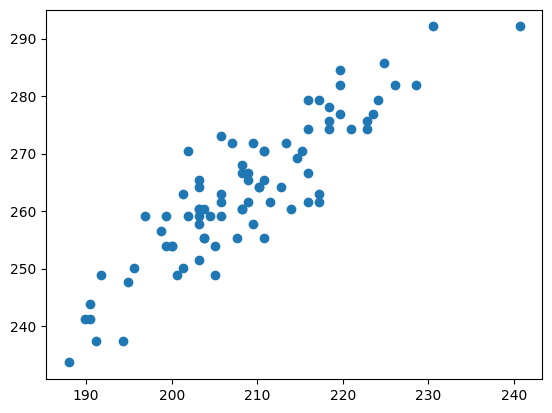

In [97]:
import matplotlib.pyplot as plt
plt.scatter(data['wingspan'], data['standing_reach'])

In [70]:
x = data['height'].values[0]
ft, inch = x.split(' ')
ft = int(ft.strip("'"))
inch = float(inch.strip("'"))

2.54 * (12 * ft + inch)

197.485

In [60]:
data[['name', 'height', 'standing_reach', 'wingspan']]

,name,height,standing_reach,wingspan
0,Michael Ajayi,6' 5.75'',8' 10.50'',7' 0.75''
1,Melvin Ajinca,6' 7.25'',8' 10.5'',6' 7.5''
2,Trey Alexander,6' 3.25'',8' 5.50'',6' 10.50''
3,Izan Almansa,6' 9.25'',9' 2.00'',7' 1.00''
4,Reece Beekman,6' 1.25'',8' 4.00'',6' 6.50''
...,...,...,...,...
78,Ja'Kobe Walter,6' 4.25'',8' 6.50'',6' 10.00''
79,Kel'el Ware,6' 11.75'',9' 4.50'',7' 4.50''
80,Jamir Watkins,6' 5.00'',8' 8.00'',6' 10.75''
81,Jaylen Wells,6' 6.50'',8' 7.50'',6' 7.25''


In [86]:
import os
import numpy as np
for year in np.arange(2003, 2025) :
    with open(f"data/combine_anthro/report_{year}.txt", "w") as file:
        pass